In [2]:
!pip install tensorflow==2.11.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.11.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.11.0


In [1]:
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git

  Cloning https://github.com/VenkateshwaranB/stellargraph.git to c:\users\venka\appdata\local\temp\pip-req-build-iaz5s6p_
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 2.1/376.0 MB 11.8 MB/s eta 0:00:32
    --------------------------------------- 4.7/376.0 MB 11.4 MB/s eta 0:00:33
    --------------------------------------- 7.3/376.0 MB 11.6 MB/s eta 0:00:32
   - -------------------------------------- 9.7/376.0 MB 11.6 MB/s eta 0:00:32
   - -------------------------------------- 12.3/376.0 MB 11.7 MB/s eta 0:00:32
   - -------------------------------------- 14.7/376.0 MB 11.7 MB/s eta 0:00:31
   - -------------------------------------- 17.3/376.0 MB 11.7 MB/s eta 0:00:31
   -- -----------------------------

  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git 'C:\Users\venka\AppData\Local\Temp\pip-req-build-iaz5s6p_'


In [ ]:
!python --version

Python 3.10.12


In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

The below cell include all the things you just run this cell only. and make sure the drive name was appropriate.

In [ ]:
well_list = ["16a","4","5a"]
well_name = ''
for j in range(len(well_list)):
  well_name = well_list[j]
  print(well_name)
  if well_name != '':
    for i in range(5, 11):
      cls_name = i
      for k in range(1, 5):
        time = k
        # the base_directory property tells us where it was downloaded to:
        cora_cites_file = os.path.join("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/", "mckee-"+str(well_name)+" BF node for "+str(cls_name)+".csv")
        cora_content_file = os.path.join("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/", "mckee-"+str(well_name)+" BF_full_edge "+str(cls_name)+".txt")

        cora_cites_cont = pd.read_csv(
            cora_cites_file)

        cora_cites = pd.DataFrame()
        #cora_cites['target'] = cora_cites['target'].str.replace('.', '')
        cora_cites['target'] = cora_cites_cont['full'].map(lambda x: str(x).replace('.', ''))
        cora_cites['source'] = cora_cites_cont['full1'].map(lambda x: str(x).replace('.', ''))

        cora_feature_names = [f"w{i}" for i in range(14)]

        cora_raw_content = pd.read_csv(
            cora_content_file,
            sep="\t",  # tab-separated
            header=None,  # no heading row
            names=["DEPTH", *cora_feature_names, "RESULTS"],  # set our own names for the columns
        )
        cora_raw_content['DEPTH'] = cora_raw_content['DEPTH'].map(lambda x: str(x).replace('.', ''))

        cora_content_str_subject = cora_raw_content.set_index("DEPTH")

        cora_content_no_subject = cora_content_str_subject.drop(columns="RESULTS")
        G = StellarGraph({"paper": cora_content_no_subject}, {"cites": cora_cites})

        node_subjects = cora_content_str_subject["RESULTS"]

        trainS = ''
        trainT = ''

        if well_name == "16a":
          trainS = 320
          trainT =143
        elif well_name == "4":
          trainS = 4506
          trainT =520
        elif well_name == "5a":
          trainS = 3553
          trainT =301

        train_subjects, test_subjects = model_selection.train_test_split(
            node_subjects, train_size=trainS, test_size=None, stratify=node_subjects
        )
        val_subjects, test_subjects = model_selection.train_test_split(
            test_subjects, train_size=trainT, test_size=None, stratify=test_subjects
        )

        target_encoding = preprocessing.LabelBinarizer()

        train_targets = target_encoding.fit_transform(train_subjects)
        val_targets = target_encoding.transform(val_subjects)
        test_targets = target_encoding.transform(test_subjects)

        generator = FullBatchNodeGenerator(G, method="gcn")

        train_gen = generator.flow(train_subjects.index, train_targets)

        gcn = GCN(
            layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
        )

        x_inp, x_out = gcn.in_out_tensors()

        predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

        model = Model(inputs=x_inp, outputs=predictions)
        model.compile(
            optimizer=optimizers.Adam(lr=0.01),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )

        from tensorflow.keras.callbacks import EarlyStopping

        es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

        val_gen = generator.flow(val_subjects.index, val_targets)

        history = model.fit(
            train_gen,
            epochs=200,
            validation_data=val_gen,
            verbose=2,
            shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
            callbacks=[es_callback],
        )

        hist_df = pd.DataFrame(history.history)

        if time == 1:
          hist_df.to_excel("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/results/History_"+str(cls_name)+".xlsx")
        else:
          hist_df.to_excel("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/results/History_"+str(cls_name)+"new"+str(time)+".xlsx")

        test_gen = generator.flow(test_subjects.index, test_targets)

        test_metrics = model.evaluate(test_gen)
        print("\nTest Set Metrics:")
        for name, val in zip(model.metrics_names, test_metrics):
            print("\t{}: {:0.4f}".format(name, val))

        all_nodes = node_subjects.index
        all_gen = generator.flow(all_nodes)
        all_predictions = model.predict(all_gen)

        node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

        df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})

        if time == 1:
          df.to_excel("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/results/Results_"+str(cls_name)+".xlsx")
        else:
          df.to_excel("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/results/Results_"+str(cls_name)+" new"+str(time)+".xlsx")

5a
Using GCN (local pooling) filters...


Epoch 1/200
1/1 - 2s - loss: 1.2492 - acc: 0.8660 - val_loss: 1.2365 - val_acc: 0.8738 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 1s - loss: 1.2351 - acc: 0.8688 - val_loss: 1.2153 - val_acc: 0.8738 - 603ms/epoch - 603ms/step
Epoch 3/200
1/1 - 1s - loss: 1.2238 - acc: 0.8669 - val_loss: 1.1943 - val_acc: 0.8738 - 635ms/epoch - 635ms/step
Epoch 4/200
1/1 - 1s - loss: 1.2098 - acc: 0.8708 - val_loss: 1.1740 - val_acc: 0.8738 - 625ms/epoch - 625ms/step
Epoch 5/200
1/1 - 1s - loss: 1.1667 - acc: 0.8725 - val_loss: 1.1537 - val_acc: 0.8738 - 561ms/epoch - 561ms/step
Epoch 6/200
1/1 - 1s - loss: 1.1535 - acc: 0.8683 - val_loss: 1.1335 - val_acc: 0.8738 - 531ms/epoch - 531ms/step
Epoch 7/200
1/1 - 1s - loss: 1.1354 - acc: 0.8733 - val_loss: 1.1135 - val_acc: 0.8738 - 565ms/epoch - 565ms/step
Epoch 8/200
1/1 - 1s - loss: 1.1070 - acc: 0.8750 - val_loss: 1.0935 - val_acc: 0.8738 - 548ms/epoch - 548ms/step
Epoch 9/200
1/1 - 1s - loss: 1.0958 - acc: 0.8742 - val_loss: 1.0737 - val_acc: 0.8738 - 553ms

Epoch 1/200
1/1 - 2s - loss: 1.6770 - acc: 0.0059 - val_loss: 1.6658 - val_acc: 0.0100 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 1s - loss: 1.6568 - acc: 0.0025 - val_loss: 1.6490 - val_acc: 0.0100 - 526ms/epoch - 526ms/step
Epoch 3/200
1/1 - 1s - loss: 1.6466 - acc: 0.0051 - val_loss: 1.6324 - val_acc: 0.0100 - 518ms/epoch - 518ms/step
Epoch 4/200
1/1 - 1s - loss: 1.6324 - acc: 0.0039 - val_loss: 1.6158 - val_acc: 0.0100 - 617ms/epoch - 617ms/step
Epoch 5/200
1/1 - 1s - loss: 1.6176 - acc: 0.0037 - val_loss: 1.5993 - val_acc: 0.0133 - 513ms/epoch - 513ms/step
Epoch 6/200
1/1 - 1s - loss: 1.5981 - acc: 0.0121 - val_loss: 1.5830 - val_acc: 0.0133 - 530ms/epoch - 530ms/step
Epoch 7/200
1/1 - 1s - loss: 1.5835 - acc: 0.0070 - val_loss: 1.5667 - val_acc: 0.0133 - 518ms/epoch - 518ms/step
Epoch 8/200
1/1 - 1s - loss: 1.5670 - acc: 0.0287 - val_loss: 1.5506 - val_acc: 0.0166 - 619ms/epoch - 619ms/step
Epoch 9/200
1/1 - 1s - loss: 1.5553 - acc: 0.0191 - val_loss: 1.5342 - val_acc: 0.0266 - 620ms

Epoch 1/200
1/1 - 2s - loss: 1.7724 - acc: 8.4436e-04 - val_loss: 1.7556 - val_acc: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 1s - loss: 1.7592 - acc: 8.4436e-04 - val_loss: 1.7416 - val_acc: 0.0000e+00 - 608ms/epoch - 608ms/step
Epoch 3/200
1/1 - 1s - loss: 1.7378 - acc: 0.0017 - val_loss: 1.7283 - val_acc: 0.0000e+00 - 516ms/epoch - 516ms/step
Epoch 4/200
1/1 - 1s - loss: 1.7289 - acc: 0.0011 - val_loss: 1.7158 - val_acc: 0.0000e+00 - 619ms/epoch - 619ms/step
Epoch 5/200
1/1 - 1s - loss: 1.7216 - acc: 8.4436e-04 - val_loss: 1.7034 - val_acc: 0.0000e+00 - 913ms/epoch - 913ms/step
Epoch 6/200
1/1 - 1s - loss: 1.7102 - acc: 8.4436e-04 - val_loss: 1.6913 - val_acc: 0.0000e+00 - 1s/epoch - 1s/step
Epoch 7/200
1/1 - 1s - loss: 1.6884 - acc: 8.4436e-04 - val_loss: 1.6793 - val_acc: 0.0000e+00 - 936ms/epoch - 936ms/step
Epoch 8/200
1/1 - 1s - loss: 1.6821 - acc: 8.4436e-04 - val_loss: 1.6674 - val_acc: 0.0000e+00 - 1s/epoch - 1s/step
Epoch 9/200
1/1 - 1s - loss: 1.6672 - acc: 0.0011 

Epoch 1/200
1/1 - 3s - loss: 1.7217 - acc: 0.0737 - val_loss: 1.6994 - val_acc: 0.0963 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 1s - loss: 1.7026 - acc: 0.1058 - val_loss: 1.6773 - val_acc: 0.1030 - 1s/epoch - 1s/step
Epoch 3/200
1/1 - 1s - loss: 1.6707 - acc: 0.1053 - val_loss: 1.6556 - val_acc: 0.1096 - 774ms/epoch - 774ms/step
Epoch 4/200
1/1 - 1s - loss: 1.6531 - acc: 0.1022 - val_loss: 1.6342 - val_acc: 0.1096 - 788ms/epoch - 788ms/step
Epoch 5/200
1/1 - 1s - loss: 1.6291 - acc: 0.1055 - val_loss: 1.6131 - val_acc: 0.1096 - 786ms/epoch - 786ms/step
Epoch 6/200
1/1 - 1s - loss: 1.6096 - acc: 0.1061 - val_loss: 1.5930 - val_acc: 0.1096 - 509ms/epoch - 509ms/step
Epoch 7/200
1/1 - 1s - loss: 1.5907 - acc: 0.1041 - val_loss: 1.5738 - val_acc: 0.1096 - 610ms/epoch - 610ms/step
Epoch 8/200
1/1 - 1s - loss: 1.5742 - acc: 0.1070 - val_loss: 1.5552 - val_acc: 0.1096 - 519ms/epoch - 519ms/step
Epoch 9/200
1/1 - 1s - loss: 1.5538 - acc: 0.1033 - val_loss: 1.5368 - val_acc: 0.1096 - 506ms/epoch

Epoch 1/200
1/1 - 2s - loss: 1.4656 - acc: 0.0169 - val_loss: 1.4383 - val_acc: 0.0033 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 1s - loss: 1.4453 - acc: 0.0121 - val_loss: 1.4175 - val_acc: 0.0033 - 609ms/epoch - 609ms/step
Epoch 3/200
1/1 - 1s - loss: 1.4250 - acc: 0.0343 - val_loss: 1.3967 - val_acc: 0.5349 - 523ms/epoch - 523ms/step
Epoch 4/200
1/1 - 1s - loss: 1.4035 - acc: 0.5471 - val_loss: 1.3760 - val_acc: 0.5415 - 524ms/epoch - 524ms/step
Epoch 5/200
1/1 - 1s - loss: 1.3729 - acc: 0.6744 - val_loss: 1.3556 - val_acc: 0.6346 - 613ms/epoch - 613ms/step
Epoch 6/200
1/1 - 1s - loss: 1.3672 - acc: 0.5913 - val_loss: 1.3356 - val_acc: 0.7674 - 614ms/epoch - 614ms/step
Epoch 7/200
1/1 - 1s - loss: 1.3318 - acc: 0.7115 - val_loss: 1.3159 - val_acc: 0.8704 - 610ms/epoch - 610ms/step
Epoch 8/200
1/1 - 1s - loss: 1.3177 - acc: 0.7537 - val_loss: 1.2957 - val_acc: 0.8738 - 611ms/epoch - 611ms/step
Epoch 9/200
1/1 - 1s - loss: 1.3017 - acc: 0.8410 - val_loss: 1.2757 - val_acc: 0.8738 - 609ms

1/1 [==============================] - 0s 349ms/step
Using GCN (local pooling) filters...


Epoch 1/200
1/1 - 3s - loss: 1.8521 - acc: 0.0042 - val_loss: 1.8303 - val_acc: 0.0033 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 1s - loss: 1.8276 - acc: 0.0023 - val_loss: 1.8154 - val_acc: 0.0033 - 772ms/epoch - 772ms/step
Epoch 3/200
1/1 - 1s - loss: 1.8133 - acc: 0.0037 - val_loss: 1.8016 - val_acc: 0.0033 - 780ms/epoch - 780ms/step
Epoch 4/200
1/1 - 1s - loss: 1.8062 - acc: 0.0037 - val_loss: 1.7872 - val_acc: 0.0033 - 686ms/epoch - 686ms/step
Epoch 5/200
1/1 - 1s - loss: 1.7941 - acc: 0.0045 - val_loss: 1.7727 - val_acc: 0.0033 - 609ms/epoch - 609ms/step
Epoch 6/200
1/1 - 1s - loss: 1.7784 - acc: 0.0051 - val_loss: 1.7582 - val_acc: 0.0033 - 506ms/epoch - 506ms/step
Epoch 7/200
1/1 - 1s - loss: 1.7577 - acc: 0.0056 - val_loss: 1.7438 - val_acc: 0.0033 - 524ms/epoch - 524ms/step
Epoch 8/200
1/1 - 1s - loss: 1.7437 - acc: 0.0039 - val_loss: 1.7295 - val_acc: 0.0033 - 611ms/epoch - 611ms/step
Epoch 9/200
1/1 - 1s - loss: 1.7300 - acc: 0.0065 - val_loss: 1.7149 - val_acc: 0.0033 - 620ms

1/1 [==============================] - 0s 364ms/step
Using GCN (local pooling) filters...


Epoch 1/200
1/1 - 2s - loss: 1.5387 - acc: 0.0115 - val_loss: 1.5240 - val_acc: 0.0066 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 1s - loss: 1.5155 - acc: 0.0250 - val_loss: 1.4980 - val_acc: 0.0066 - 513ms/epoch - 513ms/step
Epoch 3/200
1/1 - 1s - loss: 1.4834 - acc: 0.0129 - val_loss: 1.4723 - val_acc: 0.0066 - 509ms/epoch - 509ms/step
Epoch 4/200
1/1 - 1s - loss: 1.4518 - acc: 0.0183 - val_loss: 1.4465 - val_acc: 0.0066 - 509ms/epoch - 509ms/step
Epoch 5/200
1/1 - 1s - loss: 1.4221 - acc: 0.0132 - val_loss: 1.4200 - val_acc: 0.0066 - 614ms/epoch - 614ms/step
Epoch 6/200
1/1 - 1s - loss: 1.4124 - acc: 0.0231 - val_loss: 1.3937 - val_acc: 0.0066 - 608ms/epoch - 608ms/step
Epoch 7/200
1/1 - 1s - loss: 1.3790 - acc: 0.0169 - val_loss: 1.3669 - val_acc: 0.0066 - 615ms/epoch - 615ms/step
Epoch 8/200
1/1 - 1s - loss: 1.3631 - acc: 0.0239 - val_loss: 1.3402 - val_acc: 0.0066 - 602ms/epoch - 602ms/step
Epoch 9/200
1/1 - 1s - loss: 1.3265 - acc: 0.0200 - val_loss: 1.3134 - val_acc: 0.0066 - 511ms

Epoch 1/200
1/1 - 2s - loss: 1.4524 - acc: 0.0070 - val_loss: 1.4338 - val_acc: 0.0100 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.4269 - acc: 0.0051 - val_loss: 1.4132 - val_acc: 0.0100 - 470ms/epoch - 470ms/step
Epoch 3/200
1/1 - 0s - loss: 1.4160 - acc: 0.0172 - val_loss: 1.3928 - val_acc: 0.0299 - 471ms/epoch - 471ms/step
Epoch 4/200
1/1 - 1s - loss: 1.4033 - acc: 0.1323 - val_loss: 1.3725 - val_acc: 0.1196 - 563ms/epoch - 563ms/step
Epoch 5/200
1/1 - 1s - loss: 1.3780 - acc: 0.1179 - val_loss: 1.3523 - val_acc: 0.6611 - 572ms/epoch - 572ms/step
Epoch 6/200
1/1 - 1s - loss: 1.3565 - acc: 0.5376 - val_loss: 1.3322 - val_acc: 0.6844 - 571ms/epoch - 571ms/step
Epoch 7/200
1/1 - 1s - loss: 1.3400 - acc: 0.7087 - val_loss: 1.3122 - val_acc: 0.8106 - 564ms/epoch - 564ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3215 - acc: 0.8401 - val_loss: 1.2918 - val_acc: 0.8738 - 481ms/epoch - 481ms/step
Epoch 9/200
1/1 - 1s - loss: 1.3035 - acc: 0.8033 - val_loss: 1.2722 - val_acc: 0.8738 - 557ms

Epoch 1/200
1/1 - 3s - loss: 1.7325 - acc: 0.0059 - val_loss: 1.7032 - val_acc: 0.0000e+00 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 1s - loss: 1.7064 - acc: 0.0039 - val_loss: 1.6824 - val_acc: 0.0000e+00 - 749ms/epoch - 749ms/step
Epoch 3/200
1/1 - 0s - loss: 1.6813 - acc: 0.0056 - val_loss: 1.6620 - val_acc: 0.0000e+00 - 496ms/epoch - 496ms/step
Epoch 4/200
1/1 - 0s - loss: 1.6692 - acc: 0.0042 - val_loss: 1.6438 - val_acc: 0.0000e+00 - 496ms/epoch - 496ms/step
Epoch 5/200
1/1 - 1s - loss: 1.6616 - acc: 0.0042 - val_loss: 1.6261 - val_acc: 0.0000e+00 - 607ms/epoch - 607ms/step
Epoch 6/200
1/1 - 1s - loss: 1.6378 - acc: 0.0189 - val_loss: 1.6088 - val_acc: 0.0000e+00 - 600ms/epoch - 600ms/step
Epoch 7/200
1/1 - 1s - loss: 1.6158 - acc: 0.0180 - val_loss: 1.5922 - val_acc: 0.0000e+00 - 602ms/epoch - 602ms/step
Epoch 8/200
1/1 - 1s - loss: 1.6046 - acc: 0.0090 - val_loss: 1.5760 - val_acc: 0.0299 - 500ms/epoch - 500ms/step
Epoch 9/200
1/1 - 1s - loss: 1.5760 - acc: 0.1497 - val_loss: 1.55

Epoch 1/200
1/1 - 3s - loss: 1.6718 - acc: 0.0386 - val_loss: 1.6395 - val_acc: 0.0233 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 1s - loss: 1.6485 - acc: 0.0436 - val_loss: 1.6140 - val_acc: 0.0199 - 760ms/epoch - 760ms/step
Epoch 3/200
1/1 - 1s - loss: 1.6356 - acc: 0.0619 - val_loss: 1.5887 - val_acc: 0.0299 - 768ms/epoch - 768ms/step
Epoch 4/200
1/1 - 1s - loss: 1.5859 - acc: 0.0808 - val_loss: 1.5635 - val_acc: 0.0299 - 757ms/epoch - 757ms/step
Epoch 5/200
1/1 - 1s - loss: 1.5760 - acc: 0.2052 - val_loss: 1.5382 - val_acc: 0.5681 - 608ms/epoch - 608ms/step
Epoch 6/200
1/1 - 1s - loss: 1.5408 - acc: 0.6395 - val_loss: 1.5127 - val_acc: 0.6412 - 603ms/epoch - 603ms/step
Epoch 7/200
1/1 - 1s - loss: 1.5414 - acc: 0.6853 - val_loss: 1.4874 - val_acc: 0.8040 - 605ms/epoch - 605ms/step
Epoch 8/200
1/1 - 1s - loss: 1.5097 - acc: 0.6924 - val_loss: 1.4622 - val_acc: 0.8106 - 592ms/epoch - 592ms/step
Epoch 9/200
1/1 - 0s - loss: 1.4594 - acc: 0.7388 - val_loss: 1.4371 - val_acc: 0.8106 - 490ms

Epoch 1/200
1/1 - 2s - loss: 1.4715 - acc: 0.7053 - val_loss: 1.4588 - val_acc: 0.7475 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 1s - loss: 1.4516 - acc: 0.7971 - val_loss: 1.4400 - val_acc: 0.8738 - 502ms/epoch - 502ms/step
Epoch 3/200
1/1 - 1s - loss: 1.4334 - acc: 0.8083 - val_loss: 1.4213 - val_acc: 0.8738 - 504ms/epoch - 504ms/step
Epoch 4/200
1/1 - 1s - loss: 1.4284 - acc: 0.7979 - val_loss: 1.4028 - val_acc: 0.8738 - 611ms/epoch - 611ms/step
Epoch 5/200
1/1 - 1s - loss: 1.4022 - acc: 0.8472 - val_loss: 1.3846 - val_acc: 0.8738 - 502ms/epoch - 502ms/step
Epoch 6/200
1/1 - 1s - loss: 1.3880 - acc: 0.8534 - val_loss: 1.3673 - val_acc: 0.8738 - 601ms/epoch - 601ms/step
Epoch 7/200
1/1 - 1s - loss: 1.3667 - acc: 0.8435 - val_loss: 1.3514 - val_acc: 0.8738 - 597ms/epoch - 597ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3626 - acc: 0.8593 - val_loss: 1.3353 - val_acc: 0.8738 - 497ms/epoch - 497ms/step
Epoch 9/200
1/1 - 1s - loss: 1.3335 - acc: 0.8576 - val_loss: 1.3192 - val_acc: 0.8738 - 664ms

Epoch 1/200
1/1 - 3s - loss: 1.5492 - acc: 0.4272 - val_loss: 1.5336 - val_acc: 0.5581 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 1s - loss: 1.5339 - acc: 0.5457 - val_loss: 1.5203 - val_acc: 0.5581 - 752ms/epoch - 752ms/step
Epoch 3/200
1/1 - 1s - loss: 1.5224 - acc: 0.5533 - val_loss: 1.5070 - val_acc: 0.5581 - 759ms/epoch - 759ms/step
Epoch 4/200
1/1 - 1s - loss: 1.5088 - acc: 0.5770 - val_loss: 1.4941 - val_acc: 0.5581 - 689ms/epoch - 689ms/step
Epoch 5/200
1/1 - 0s - loss: 1.4882 - acc: 0.5654 - val_loss: 1.4816 - val_acc: 0.5648 - 498ms/epoch - 498ms/step
Epoch 6/200
1/1 - 1s - loss: 1.4732 - acc: 0.5944 - val_loss: 1.4692 - val_acc: 0.5714 - 511ms/epoch - 511ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4759 - acc: 0.5975 - val_loss: 1.4571 - val_acc: 0.6146 - 499ms/epoch - 499ms/step
Epoch 8/200
1/1 - 1s - loss: 1.4418 - acc: 0.6836 - val_loss: 1.4458 - val_acc: 0.7542 - 510ms/epoch - 510ms/step
Epoch 9/200
1/1 - 1s - loss: 1.4553 - acc: 0.7250 - val_loss: 1.4351 - val_acc: 0.8738 - 608ms

Using GCN (local pooling) filters...
Epoch 1/200
1/1 - 3s - loss: 1.7578 - acc: 0.0988 - val_loss: 1.7328 - val_acc: 0.0997 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.7365 - acc: 0.0994 - val_loss: 1.7161 - val_acc: 0.0997 - 457ms/epoch - 457ms/step
Epoch 3/200
1/1 - 0s - loss: 1.7214 - acc: 0.0971 - val_loss: 1.6997 - val_acc: 0.1096 - 484ms/epoch - 484ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7072 - acc: 0.1084 - val_loss: 1.6836 - val_acc: 0.1096 - 467ms/epoch - 467ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6908 - acc: 0.0994 - val_loss: 1.6678 - val_acc: 0.1130 - 430ms/epoch - 430ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6775 - acc: 0.1106 - val_loss: 1.6523 - val_acc: 0.1130 - 380ms/epoch - 380ms/step
Epoch 7/200
1/1 - 0s - loss: 1.6614 - acc: 0.1002 - val_loss: 1.6373 - val_acc: 0.1130 - 372ms/epoch - 372ms/step
Epoch 8/200
1/1 - 0s - loss: 1.6465 - acc: 0.1106 - val_loss: 1.6223 - val_acc: 0.1130 - 374ms/epoch - 374ms/step
Epoch 9/200
1/1 - 0s - loss: 1.6321 - acc: 0.1120 - val_l

Using GCN (local pooling) filters...
Epoch 1/200
1/1 - 4s - loss: 1.6398 - acc: 0.0099 - val_loss: 1.6213 - val_acc: 0.0066 - 4s/epoch - 4s/step
Epoch 2/200
1/1 - 0s - loss: 1.6207 - acc: 0.0121 - val_loss: 1.6019 - val_acc: 0.0066 - 431ms/epoch - 431ms/step
Epoch 3/200
1/1 - 1s - loss: 1.6057 - acc: 0.0099 - val_loss: 1.5826 - val_acc: 0.0066 - 567ms/epoch - 567ms/step
Epoch 4/200
1/1 - 0s - loss: 1.5810 - acc: 0.0346 - val_loss: 1.5633 - val_acc: 0.0066 - 416ms/epoch - 416ms/step
Epoch 5/200
1/1 - 0s - loss: 1.5645 - acc: 0.0661 - val_loss: 1.5443 - val_acc: 0.0266 - 361ms/epoch - 361ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5491 - acc: 0.0766 - val_loss: 1.5256 - val_acc: 0.1030 - 363ms/epoch - 363ms/step
Epoch 7/200
1/1 - 0s - loss: 1.5280 - acc: 0.1511 - val_loss: 1.5072 - val_acc: 0.3189 - 351ms/epoch - 351ms/step
Epoch 8/200
1/1 - 0s - loss: 1.5120 - acc: 0.2460 - val_loss: 1.4887 - val_acc: 0.3787 - 357ms/epoch - 357ms/step
Epoch 9/200
1/1 - 0s - loss: 1.4876 - acc: 0.2888 - val_l

Epoch 1/200
1/1 - 2s - loss: 2.2238 - acc: 0.0084 - val_loss: 2.1920 - val_acc: 0.0100 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 2.1965 - acc: 0.0073 - val_loss: 2.1573 - val_acc: 0.0100 - 249ms/epoch - 249ms/step
Epoch 3/200
1/1 - 0s - loss: 2.1679 - acc: 0.0073 - val_loss: 2.1228 - val_acc: 0.0066 - 229ms/epoch - 229ms/step
Epoch 4/200
1/1 - 0s - loss: 2.1033 - acc: 0.0070 - val_loss: 2.0886 - val_acc: 0.0066 - 289ms/epoch - 289ms/step
Epoch 5/200
1/1 - 0s - loss: 2.0919 - acc: 0.0079 - val_loss: 2.0547 - val_acc: 0.0033 - 246ms/epoch - 246ms/step
Epoch 6/200
1/1 - 0s - loss: 2.0432 - acc: 0.0070 - val_loss: 2.0212 - val_acc: 0.0033 - 228ms/epoch - 228ms/step
Epoch 7/200
1/1 - 0s - loss: 2.0238 - acc: 0.0082 - val_loss: 1.9880 - val_acc: 0.0033 - 243ms/epoch - 243ms/step
Epoch 8/200
1/1 - 0s - loss: 1.9845 - acc: 0.0062 - val_loss: 1.9551 - val_acc: 0.0066 - 231ms/epoch - 231ms/step
Epoch 9/200
1/1 - 0s - loss: 1.9667 - acc: 0.0068 - val_loss: 1.9225 - val_acc: 0.0066 - 289ms

Using GCN (local pooling) filters...
Epoch 1/200
1/1 - 2s - loss: 1.7387 - acc: 0.0177 - val_loss: 1.7122 - val_acc: 0.0133 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.7209 - acc: 0.0121 - val_loss: 1.6932 - val_acc: 0.0133 - 461ms/epoch - 461ms/step
Epoch 3/200
1/1 - 1s - loss: 1.7061 - acc: 0.0172 - val_loss: 1.6750 - val_acc: 0.0133 - 588ms/epoch - 588ms/step
Epoch 4/200
1/1 - 1s - loss: 1.6744 - acc: 0.0225 - val_loss: 1.6571 - val_acc: 0.0133 - 581ms/epoch - 581ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6559 - acc: 0.0127 - val_loss: 1.6395 - val_acc: 0.0133 - 451ms/epoch - 451ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6486 - acc: 0.0194 - val_loss: 1.6223 - val_acc: 0.0133 - 407ms/epoch - 407ms/step
Epoch 7/200
1/1 - 0s - loss: 1.6241 - acc: 0.0180 - val_loss: 1.6055 - val_acc: 0.0133 - 388ms/epoch - 388ms/step
Epoch 8/200
1/1 - 0s - loss: 1.6171 - acc: 0.0504 - val_loss: 1.5891 - val_acc: 0.0133 - 374ms/epoch - 374ms/step
Epoch 9/200
1/1 - 1s - loss: 1.5943 - acc: 0.0172 - val_l

Epoch 1/200
1/1 - 2s - loss: 1.7993 - acc: 0.0090 - val_loss: 1.7767 - val_acc: 0.0066 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.7774 - acc: 0.0160 - val_loss: 1.7572 - val_acc: 0.0066 - 233ms/epoch - 233ms/step
Epoch 3/200
1/1 - 0s - loss: 1.7437 - acc: 0.0132 - val_loss: 1.7378 - val_acc: 0.0066 - 296ms/epoch - 296ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7443 - acc: 0.0245 - val_loss: 1.7184 - val_acc: 0.0066 - 487ms/epoch - 487ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6982 - acc: 0.0276 - val_loss: 1.6992 - val_acc: 0.0066 - 447ms/epoch - 447ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6947 - acc: 0.0332 - val_loss: 1.6801 - val_acc: 0.0066 - 417ms/epoch - 417ms/step
Epoch 7/200
1/1 - 1s - loss: 1.6819 - acc: 0.0228 - val_loss: 1.6612 - val_acc: 0.0066 - 593ms/epoch - 593ms/step
Epoch 8/200
1/1 - 1s - loss: 1.6548 - acc: 0.0450 - val_loss: 1.6423 - val_acc: 0.0066 - 581ms/epoch - 581ms/step
Epoch 9/200
1/1 - 1s - loss: 1.6483 - acc: 0.0419 - val_loss: 1.6235 - val_acc: 0.0066 - 577ms

Epoch 1/200
1/1 - 3s - loss: 1.8032 - acc: 0.0115 - val_loss: 1.7853 - val_acc: 0.0166 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.7933 - acc: 0.0146 - val_loss: 1.7728 - val_acc: 0.0166 - 371ms/epoch - 371ms/step
Epoch 3/200
1/1 - 0s - loss: 1.7726 - acc: 0.0132 - val_loss: 1.7604 - val_acc: 0.0166 - 385ms/epoch - 385ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7668 - acc: 0.0124 - val_loss: 1.7482 - val_acc: 0.0166 - 369ms/epoch - 369ms/step
Epoch 5/200
1/1 - 0s - loss: 1.7619 - acc: 0.0115 - val_loss: 1.7365 - val_acc: 0.0166 - 366ms/epoch - 366ms/step
Epoch 6/200
1/1 - 0s - loss: 1.7411 - acc: 0.0110 - val_loss: 1.7251 - val_acc: 0.0365 - 386ms/epoch - 386ms/step
Epoch 7/200
1/1 - 0s - loss: 1.7251 - acc: 0.0172 - val_loss: 1.7140 - val_acc: 0.0465 - 375ms/epoch - 375ms/step
Epoch 8/200
1/1 - 0s - loss: 1.7222 - acc: 0.0228 - val_loss: 1.7031 - val_acc: 0.1096 - 298ms/epoch - 298ms/step
Epoch 9/200
1/1 - 0s - loss: 1.7076 - acc: 0.0149 - val_loss: 1.6924 - val_acc: 0.1163 - 294ms

Epoch 1/200
1/1 - 2s - loss: 1.7781 - acc: 0.1019 - val_loss: 1.7491 - val_acc: 0.1196 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.7344 - acc: 0.1084 - val_loss: 1.7154 - val_acc: 0.1196 - 423ms/epoch - 423ms/step
Epoch 3/200
1/1 - 1s - loss: 1.7122 - acc: 0.1120 - val_loss: 1.6807 - val_acc: 0.1196 - 580ms/epoch - 580ms/step
Epoch 4/200
1/1 - 1s - loss: 1.6807 - acc: 0.1081 - val_loss: 1.6459 - val_acc: 0.1196 - 591ms/epoch - 591ms/step
Epoch 5/200
1/1 - 1s - loss: 1.6400 - acc: 0.1084 - val_loss: 1.6104 - val_acc: 0.1196 - 575ms/epoch - 575ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6180 - acc: 0.1005 - val_loss: 1.5747 - val_acc: 0.1196 - 392ms/epoch - 392ms/step
Epoch 7/200
1/1 - 0s - loss: 1.5871 - acc: 0.1100 - val_loss: 1.5394 - val_acc: 0.1196 - 356ms/epoch - 356ms/step
Epoch 8/200
1/1 - 0s - loss: 1.5343 - acc: 0.1100 - val_loss: 1.5043 - val_acc: 0.1196 - 383ms/epoch - 383ms/step
Epoch 9/200
1/1 - 0s - loss: 1.5071 - acc: 0.1030 - val_loss: 1.4695 - val_acc: 0.1196 - 374ms

Epoch 1/200
1/1 - 2s - loss: 1.6869 - acc: 0.0070 - val_loss: 1.6719 - val_acc: 0.0066 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.6691 - acc: 0.0068 - val_loss: 1.6609 - val_acc: 0.0066 - 252ms/epoch - 252ms/step
Epoch 3/200
1/1 - 1s - loss: 1.6564 - acc: 0.0084 - val_loss: 1.6499 - val_acc: 0.0066 - 529ms/epoch - 529ms/step
Epoch 4/200
1/1 - 0s - loss: 1.6552 - acc: 0.0087 - val_loss: 1.6389 - val_acc: 0.0066 - 450ms/epoch - 450ms/step
Epoch 5/200
1/1 - 1s - loss: 1.6395 - acc: 0.0093 - val_loss: 1.6279 - val_acc: 0.0066 - 577ms/epoch - 577ms/step
Epoch 6/200
1/1 - 1s - loss: 1.6238 - acc: 0.0070 - val_loss: 1.6170 - val_acc: 0.0066 - 583ms/epoch - 583ms/step
Epoch 7/200
1/1 - 0s - loss: 1.6117 - acc: 0.0079 - val_loss: 1.6060 - val_acc: 0.0066 - 426ms/epoch - 426ms/step
Epoch 8/200
1/1 - 1s - loss: 1.6072 - acc: 0.0068 - val_loss: 1.5951 - val_acc: 0.0066 - 573ms/epoch - 573ms/step
Epoch 9/200
1/1 - 0s - loss: 1.5952 - acc: 0.0110 - val_loss: 1.5841 - val_acc: 0.0066 - 417ms

Using GCN (local pooling) filters...
Epoch 1/200
1/1 - 2s - loss: 1.6882 - acc: 0.0183 - val_loss: 1.6703 - val_acc: 0.0166 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.6741 - acc: 0.0270 - val_loss: 1.6592 - val_acc: 0.0166 - 150ms/epoch - 150ms/step
Epoch 3/200
1/1 - 0s - loss: 1.6670 - acc: 0.0239 - val_loss: 1.6482 - val_acc: 0.0166 - 170ms/epoch - 170ms/step
Epoch 4/200
1/1 - 0s - loss: 1.6533 - acc: 0.0304 - val_loss: 1.6376 - val_acc: 0.0166 - 165ms/epoch - 165ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6419 - acc: 0.0217 - val_loss: 1.6273 - val_acc: 0.0166 - 172ms/epoch - 172ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6336 - acc: 0.0236 - val_loss: 1.6172 - val_acc: 0.0166 - 170ms/epoch - 170ms/step
Epoch 7/200
1/1 - 0s - loss: 1.6187 - acc: 0.0701 - val_loss: 1.6071 - val_acc: 0.0166 - 147ms/epoch - 147ms/step
Epoch 8/200
1/1 - 0s - loss: 1.6093 - acc: 0.0245 - val_loss: 1.5970 - val_acc: 0.0199 - 162ms/epoch - 162ms/step
Epoch 9/200
1/1 - 0s - loss: 1.5972 - acc: 0.0256 - val_l

Epoch 1/200
1/1 - 2s - loss: 1.7112 - acc: 0.0039 - val_loss: 1.6891 - val_acc: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.7028 - acc: 0.0039 - val_loss: 1.6792 - val_acc: 0.0000e+00 - 164ms/epoch - 164ms/step
Epoch 3/200
1/1 - 0s - loss: 1.6895 - acc: 0.0031 - val_loss: 1.6693 - val_acc: 0.0000e+00 - 166ms/epoch - 166ms/step
Epoch 4/200
1/1 - 0s - loss: 1.6760 - acc: 0.0065 - val_loss: 1.6593 - val_acc: 0.0000e+00 - 164ms/epoch - 164ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6630 - acc: 0.0096 - val_loss: 1.6492 - val_acc: 0.0000e+00 - 154ms/epoch - 154ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6542 - acc: 0.0152 - val_loss: 1.6391 - val_acc: 0.0000e+00 - 159ms/epoch - 159ms/step
Epoch 7/200
1/1 - 0s - loss: 1.6464 - acc: 0.0160 - val_loss: 1.6291 - val_acc: 0.0000e+00 - 159ms/epoch - 159ms/step
Epoch 8/200
1/1 - 0s - loss: 1.6374 - acc: 0.0338 - val_loss: 1.6192 - val_acc: 0.0000e+00 - 154ms/epoch - 154ms/step
Epoch 9/200
1/1 - 0s - loss: 1.6248 - acc: 0.0231 - val_loss: 

Using GCN (local pooling) filters...
Epoch 1/200
1/1 - 2s - loss: 1.4510 - acc: 0.3954 - val_loss: 1.4701 - val_acc: 0.3256 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.4502 - acc: 0.4011 - val_loss: 1.4467 - val_acc: 0.3289 - 172ms/epoch - 172ms/step
Epoch 3/200
1/1 - 0s - loss: 1.4168 - acc: 0.4346 - val_loss: 1.4234 - val_acc: 0.3455 - 168ms/epoch - 168ms/step
Epoch 4/200
1/1 - 0s - loss: 1.4066 - acc: 0.4230 - val_loss: 1.4003 - val_acc: 0.3455 - 166ms/epoch - 166ms/step
Epoch 5/200
1/1 - 0s - loss: 1.3803 - acc: 0.4430 - val_loss: 1.3772 - val_acc: 0.3621 - 171ms/epoch - 171ms/step
Epoch 6/200
1/1 - 0s - loss: 1.3669 - acc: 0.4861 - val_loss: 1.3539 - val_acc: 0.3987 - 152ms/epoch - 152ms/step
Epoch 7/200
1/1 - 0s - loss: 1.3310 - acc: 0.5277 - val_loss: 1.3308 - val_acc: 0.4817 - 156ms/epoch - 156ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3158 - acc: 0.6473 - val_loss: 1.3078 - val_acc: 0.7375 - 159ms/epoch - 159ms/step
Epoch 9/200
1/1 - 0s - loss: 1.3041 - acc: 0.6364 - val_l

Using GCN (local pooling) filters...
Epoch 1/200
1/1 - 2s - loss: 1.9884 - acc: 0.0110 - val_loss: 2.0030 - val_acc: 0.0100 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.9948 - acc: 0.0115 - val_loss: 1.9830 - val_acc: 0.0100 - 283ms/epoch - 283ms/step
Epoch 3/200
1/1 - 0s - loss: 1.9443 - acc: 0.0113 - val_loss: 1.9634 - val_acc: 0.0100 - 318ms/epoch - 318ms/step
Epoch 4/200
1/1 - 0s - loss: 1.9252 - acc: 0.0124 - val_loss: 1.9440 - val_acc: 0.0100 - 280ms/epoch - 280ms/step
Epoch 5/200
1/1 - 0s - loss: 1.9193 - acc: 0.0090 - val_loss: 1.9248 - val_acc: 0.0100 - 275ms/epoch - 275ms/step
Epoch 6/200
1/1 - 0s - loss: 1.9012 - acc: 0.0099 - val_loss: 1.9056 - val_acc: 0.0100 - 316ms/epoch - 316ms/step
Epoch 7/200
1/1 - 0s - loss: 1.8942 - acc: 0.0096 - val_loss: 1.8866 - val_acc: 0.0100 - 319ms/epoch - 319ms/step
Epoch 8/200
1/1 - 0s - loss: 1.8617 - acc: 0.0110 - val_loss: 1.8680 - val_acc: 0.0100 - 316ms/epoch - 316ms/step
Epoch 9/200
1/1 - 0s - loss: 1.8380 - acc: 0.0107 - val_l

In [ ]:
cls_name = 5

In [ ]:
well_name = "5a"

In [ ]:
time = 1

In [ ]:
# the base_directory property tells us where it was downloaded to:
cora_cites_file = os.path.join("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/", "mckee-"+str(well_name)+" BF node for "+str(cls_name)+".csv")
cora_content_file = os.path.join("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/", "mckee-"+str(well_name)+" BF_full_edge "+str(cls_name)+".txt")

In [ ]:
cora_cites = pd.DataFrame()

In [ ]:
cora_cites_cont = pd.read_csv(
    cora_cites_file)


#cora_cites['target'] = cora_cites['target'].str.replace('.', '')
cora_cites['target'] = cora_cites_cont['full'].map(lambda x: str(x).replace('.', ''))
cora_cites['source'] = cora_cites_cont['full1'].map(lambda x: str(x).replace('.', ''))

In [ ]:
cora_cites

,target,source
0,170307,17032224
1,170307,17033748
2,170307,17035272
3,170307,17036796
4,170307,1703832
...,...,...
3441565,239649,2395728
3441566,239649,23958804
3441567,239649,23960328
3441568,239649,23961852


In [ ]:
cora_feature_names = [f"w{i}" for i in range(14)]

cora_raw_content = pd.read_csv(
    cora_content_file,
    sep="\t",  # tab-separated
    header=None,  # no heading row
    names=["DEPTH", *cora_feature_names, "RESULTS"],  # set our own names for the columns
)
cora_raw_content['DEPTH'] = cora_raw_content['DEPTH'].map(lambda x: str(x).replace('.', ''))

In [ ]:
cora_content_str_subject = cora_raw_content.set_index("DEPTH")

In [ ]:
cora_content_no_subject = cora_content_str_subject.drop(columns="RESULTS")

In [ ]:
G = StellarGraph({"paper": cora_content_no_subject}, {"cites": cora_cites})
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 4216, Edges: 3441570

 Node types:
  paper: [4216]
    Features: float32 vector, length 14
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [3441570]
        Weights: all 1 (default)
        Features: none


In [ ]:
node_subjects = cora_content_str_subject["RESULTS"]

In [ ]:
node_subjects

DEPTH
170307      Very_Low
17032224    Very_Low
17033748    Very_Low
17035272    Very_Low
17036796    Very_Low
              ...   
23958804    Very_Low
23960328    Very_Low
23961852    Very_Low
23963376    Very_Low
239649      Very_Low
Name: RESULTS, Length: 4216, dtype: object

In [ ]:
node_subjects.value_counts().to_frame()

,RESULTS
Very_Low,3679
High,464
Very_High,41
Moderate,29
Low,3


In [ ]:
trainS = ''
trainT = ''

if well_name == "16a":
  trainS = 320
  trainT =143
elif well_name == "4":
  trainS = 4506
  trainT =520
elif well_name == "5a":
  trainS = 3553
  trainT =301

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=trainS, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=trainT, test_size=None, stratify=test_subjects
)

ValueError: ignored

In [ ]:
train_subjects.value_counts().to_frame()

,RESULTS
High,101
Very_Low,82
Moderate,69
Low,51
Very_High,17


In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
train_targets.shape

(320, 5)

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
train_targets.shape

(320, 5)

In [ ]:
test_targets.shape

(124, 5)

In [ ]:
val_targets.shape

(143, 5)

In [ ]:
train_subjects.index

Index(['23402544', '232791', '22960584', '22835616', '22904196', '23396448',
       '233553', '22995636', '23391876', '2321052',
       ...
       '23525988', '22735032', '23440644', '22992588', '22750272', '23321772',
       '23565612', '22719792', '23266908', '23163276'],
      dtype='object', name='DEPTH', length=320)

In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices_20')>

In [ ]:
x_inp

[<KerasTensor: shape=(1, 587, 14) dtype=float32 (created by layer 'input_81')>,
 <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_82')>,
 <KerasTensor: shape=(1, None, 2) dtype=int64 (created by layer 'input_83')>,
 <KerasTensor: shape=(1, None) dtype=float32 (created by layer 'input_84')>]

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
predictions

<KerasTensor: shape=(1, None, 5) dtype=float32 (created by layer 'dense_20')>

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
inp = model.input

In [ ]:
inp

[<KerasTensor: shape=(1, 587, 14) dtype=float32 (created by layer 'input_81')>,
 <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_82')>,
 <KerasTensor: shape=(1, None, 2) dtype=int64 (created by layer 'input_83')>,
 <KerasTensor: shape=(1, None) dtype=float32 (created by layer 'input_84')>]

In [ ]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(1, 587, 14)]       0           []                               
                                                                                                  
 input_83 (InputLayer)          [(1, None, 2)]       0           []                               
                                                                                                  
 input_84 (InputLayer)          [(1, None)]          0           []                               
                                                                                                  
 dropout_40 (Dropout)           (1, 587, 14)         0           ['input_81[0][0]']               
                                                                                           

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9689 - acc: 0.0625 - val_loss: 1.9361 - val_acc: 0.0559 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.9529 - acc: 0.0719 - val_loss: 1.9236 - val_acc: 0.0559 - 66ms/epoch - 66ms/step
Epoch 3/200
1/1 - 0s - loss: 1.9093 - acc: 0.0594 - val_loss: 1.9114 - val_acc: 0.0559 - 65ms/epoch - 65ms/step
Epoch 4/200
1/1 - 0s - loss: 1.9424 - acc: 0.0531 - val_loss: 1.8995 - val_acc: 0.0559 - 60ms/epoch - 60ms/step
Epoch 5/200
1/1 - 0s - loss: 1.9153 - acc: 0.0719 - val_loss: 1.8878 - val_acc: 0.0559 - 64ms/epoch - 64ms/step
Epoch 6/200
1/1 - 0s - loss: 1.8752 - acc: 0.0594 - val_loss: 1.8764 - val_acc: 0.0559 - 70ms/epoch - 70ms/step
Epoch 7/200
1/1 - 0s - loss: 1.8935 - acc: 0.0625 - val_loss: 1.8653 - val_acc: 0.0559 - 66ms/epoch - 66ms/step
Epoch 8/200
1/1 - 0s - loss: 1.8757 - acc: 0.0719 - val_loss: 1.8545 - val_acc: 0.0559 - 62ms/epoch - 62ms/step
Epoch 9/200
1/1 - 0s - loss: 1.8453 - acc: 0.1000 - val_loss: 1.8439 - val_acc: 0.0559 - 70ms/epoch - 70ms/s

In [ ]:
hist_df = pd.DataFrame(history.history)

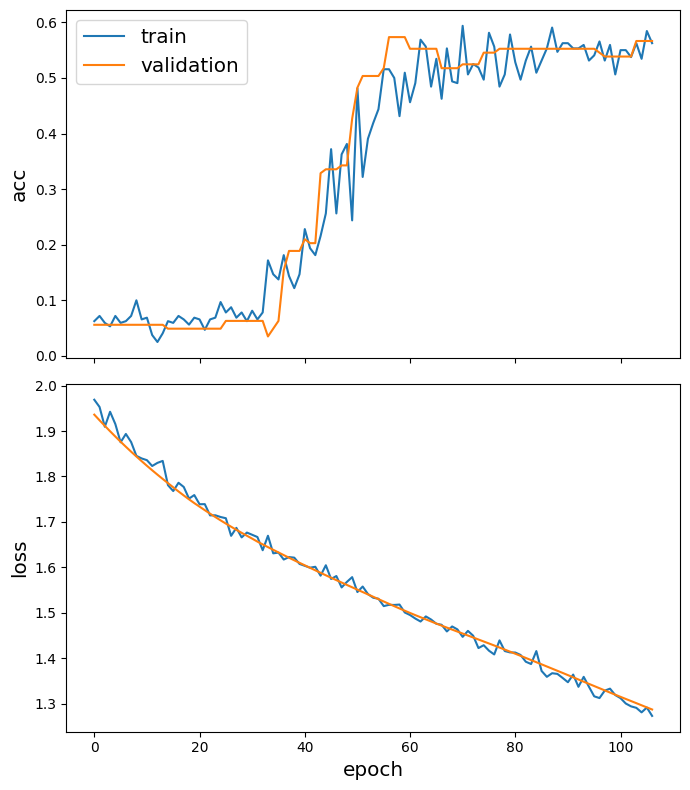

In [ ]:
sg.utils.plot_history(history)

In [ ]:
if time == 1:
  hist_df.to_excel("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/results/History_"+str(cls_name)+".xlsx")
else:
  hist_df.to_excel("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/results/History_"+str(cls_name)+"new"+str(time)+".xlsx")

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 52ms/step - loss: 1.5259 - acc: 0.5403

Test Set Metrics:
	loss: 1.5259
	acc: 0.5403


In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 146ms/step


In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(40)

,Predicted,True
DEPTH,,
22710648,Moderate,High
22712172,Moderate,High
22713696,High,High
2271522,High,High
22716744,High,High
22718268,High,High
22719792,High,High
22721316,High,High
2272284,High,High


In [ ]:
df['Predicted'].value_counts().to_frame()

,Predicted
Very_Low,284
Moderate,157
High,146


In [ ]:
df['True'].value_counts().to_frame()

,True
High,185
Very_Low,150
Moderate,127
Low,94
Very_High,31


In [ ]:
if time == 1:
  df.to_excel("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/results/Results_"+str(cls_name)+".xlsx")
else:
  df.to_excel("/content/drive/MyDrive/NewZealand_data/mckee-"+str(well_name)+"/"+str(cls_name)+"/results/Results_"+str(cls_name)+" new"+str(time)+".xlsx")